In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import math

In [13]:
def generate_lagged_inp(X,max_lag):
    X = np.array(X)
    lag_inputs = np.zeros((len(X) - max_lag, max_lag))
    for i in range(max_lag):
        lag_inputs[:, i] = X[max_lag - 1 - i: -1 - i]
    return lag_inputs

def fit_ols_model(X, Y, intercept = True):
    if intercept:
        X = sm.add_constant(X)  # Add a constant term to the exogenous variables
    model = sm.OLS(Y,X)
    fitted_model = model.fit()
    return fitted_model

class ARMAProcess:
    def __init__(self, ar_params, ma_params):
        self.ar_params = ar_params
        self.ma_params = ma_params
        
    def generate_ARMA(self,n):
        arma_process = ArmaProcess(self.ar_params, self.ma_params) ## polynomials to pass
        return arma_process.generate_sample(n)
    
    def fit_model(self, data):
        ar_model = sm.tsa.ARMA(data, order=(len(self.ar_params), len(self.ma_params)))
        fitted_model = ar_model.fit()
        return fitted_model
        
    def MC_sim_ARMA(self,MC_length,max_lag):
        estim_models = []
        for i in range(MC_length):
            generated_samples = self.generate_ARMA(1000)
            y = generated_samples 
            X = generate_lagged_inp(generated_samples,max_lag)
            OLS_fit = fit_ols_model(X,y[max_lag:],intercept = False)
            estim_models.append(OLS_fit)
        return estim_models

def get_coeffs(roots):
    temp = [1]
    for root in roots:
        temp = np.polymul(temp,[1,-root])
    return temp

def acf_analysis(data):
    data = data - np.mean(data)
    AutoCorrel = np.correlate(data,data,mode = "full")/(len(data)*np.var(data)) ### Standardize to have correls wrt 1
    return AutoCorrel[len(AutoCorrel) // 2 :]

def pacf_analysis(data,max_lags):
    ### Regress against all lags and pickup the last coefficient
    pacfs = np.zeros(max_lags + 1)
    pacfs[0] = 1
    for lag in range(1, max_lags + 1):
        y = data[lag:]
        X = np.column_stack([data[lag-k-1:-k-1] for k in range(lag)])
        PACF_info = fit_ols_model(X,y)
        pacfs[lag] = PACF_info.params[-1]
    return pacfs

def acf_pacf_analysis(series):
    acf = acf_analysis(series)
    pacfs = pacf_analysis(series,10)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    axes[0].set_title("Autocorrelation Function")
    axes[0].stem(acf[1:40])
    axes[0].grid()
    axes[0].set_xlabel("Lags")
    axes[0].set_ylabel("ACF")
    axes[1].set_title("Partial Autocorrelation Function")
    axes[1].stem(pacfs[1:40])
    axes[1].grid()
    axes[1].set_xlabel("Lags")
    axes[1].set_ylabel("PACF")

### Q4)

In [14]:
# Example usage
ar_params = [0.8]  # AR parameter
ma_params = [0.7]   # MA parameters
ar = np.r_[1,-np.array(ar_params)]
ma = np.r_[1,np.array(ma_params)]
arma_process = ARMAProcess(ar, ma)
OLS_sims_ARMA = arma_process.MC_sim_ARMA(1000,1)
residuals = OLS_sims_ARMA[100].resid
coeffs = [sim_param.params[0] for sim_param in OLS_sims_ARMA]

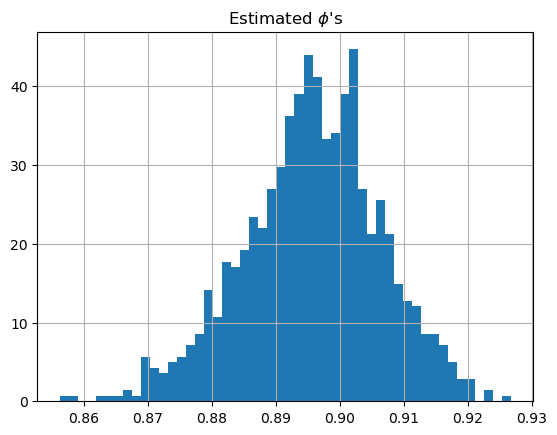

In [15]:
plt.hist(coeffs, bins = 50, density = True)
plt.title(f"Estimated $\phi$'s")
plt.grid()

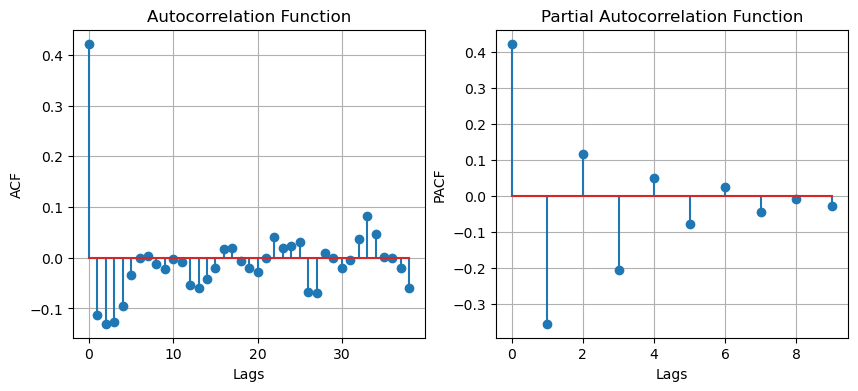

In [16]:
acf_pacf_analysis(residuals)

### Q5)

In [22]:
def plotter_monte_summary(plot_data):
    num_plots = len(plot_data)
    fig, axes = plt.subplots(nrows=1, ncols=max(num_plots,2), figsize=(num_plots*4,num_plots))
    keys = list(plot_data.keys())
    for i in range(num_plots):
        axes[i].title.set_text(f"{keys[i]}")
        axes[i].hist(plot_data[keys[i]], bins = 50, density = True )
        axes[i].grid()
    plt.show()

def summarize_AR_sim(OLS_sim,AR):
    plot_data = {}
    sim_params = [sim.params for sim in OLS_sim] 
    for i in range(AR):
        plot_data[f"$\phi_{i}$"] = np.array(sim_params)[:,i]
    mean = np.mean(np.array(sim_params),axis = 0)
    print(f"Average values of estimated params:{mean}")
    residuals = [sim.resid for sim in OLS_sim]
    avg_residuals = np.mean(np.array(residuals),axis = 0)
    print(f"ACF, PACF plots for AR_{AR}")
    acf_pacf_analysis(avg_residuals)
    plotter_monte_summary(plot_data)
    

lambdas_AR3 = [0.95,0.9,0.8]
coeffs = get_coeffs(lambdas_AR3)
AR3_process = ARMAProcess(coeffs, [1])
ARs = [1,2,3,4]
OLS_sims = {}
for AR in ARs:
    OLS_sims[f"AR{AR}"] = AR3_process.MC_sim_ARMA(1000,AR)

AR3 regressed as AR1
Average values of estimated params:[0.99881135]
ACF, PACF plots for AR_1


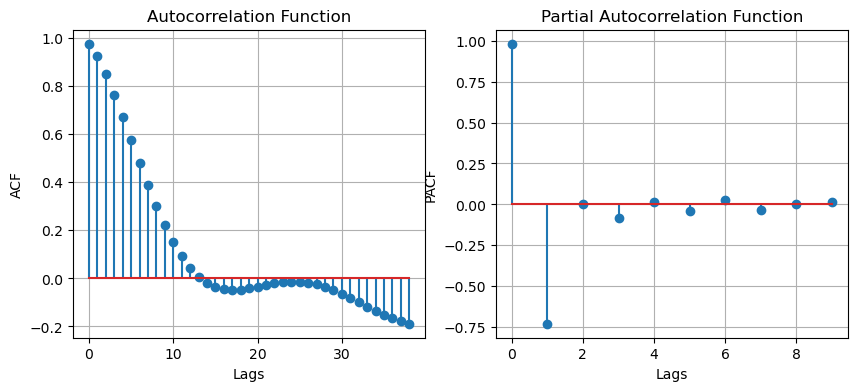

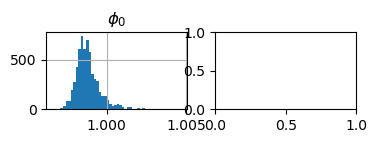

AR3 regressed as AR2
Average values of estimated params:[ 1.97888857 -0.98228108]
ACF, PACF plots for AR_2


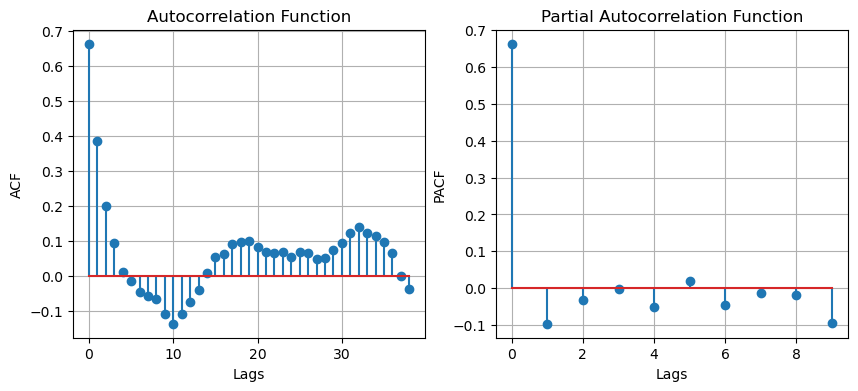

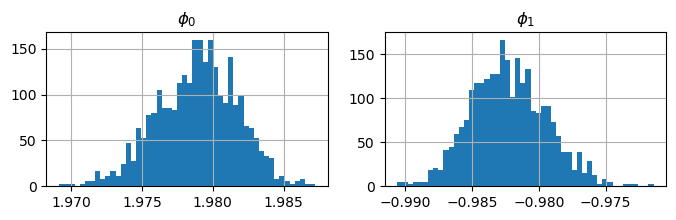

AR3 regressed as AR3
Average values of estimated params:[ 2.64712885 -2.3296602   0.68146642]
ACF, PACF plots for AR_3


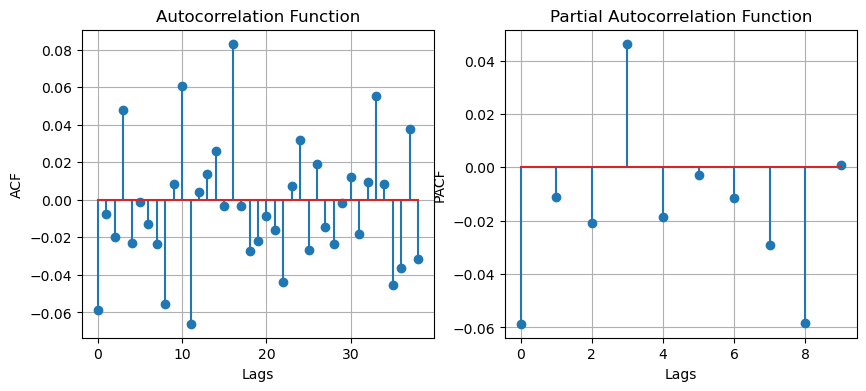

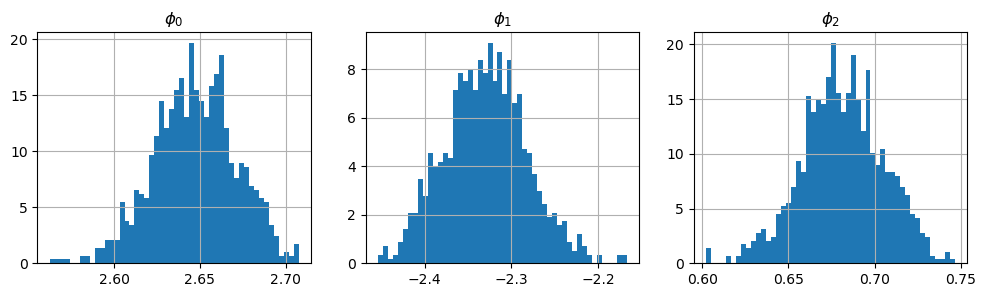

AR3 regressed as AR4
Average values of estimated params:[ 2.64635246e+00 -2.32885550e+00  6.82015981e-01 -5.81786522e-04]
ACF, PACF plots for AR_4


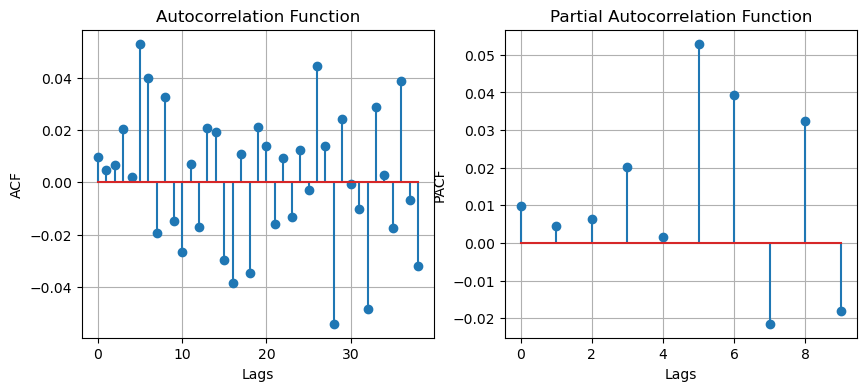

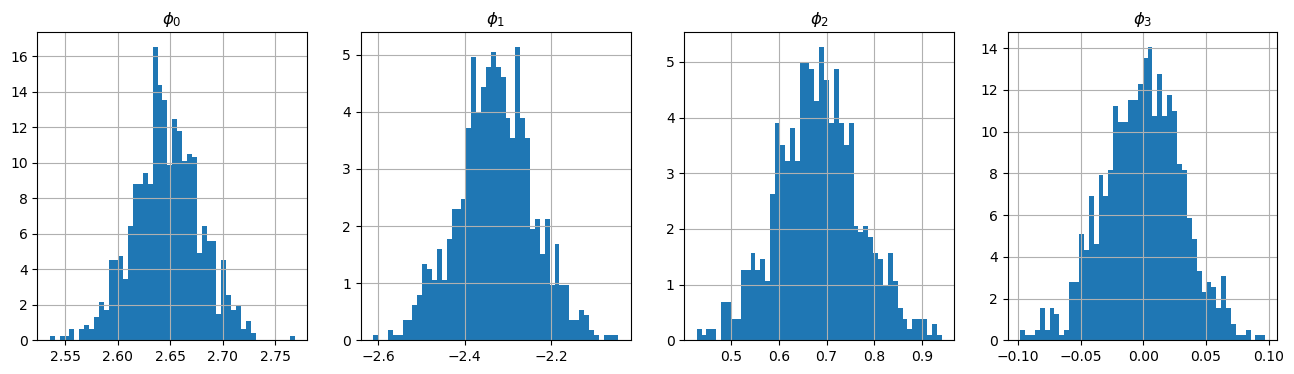

In [23]:
print("AR3 regressed as AR1")
summarize_AR_sim(OLS_sims["AR1"],1)
print("AR3 regressed as AR2")
summarize_AR_sim(OLS_sims["AR2"],2)
print("AR3 regressed as AR3")
summarize_AR_sim(OLS_sims["AR3"],3)
print("AR3 regressed as AR4")
summarize_AR_sim(OLS_sims["AR4"],4)

Few key observations are as follows:
- Clearly as we go from $AR(1)-AR(4)$, we can see that the estimated coefficients grow closer to the true coefficients
- Specifically, we can see that the PACF and ACF plots indicate that for $AR(1), AR(2)$ there is some left over correlation in the residuals which is captured at first few lags
- This disappears as we move to $AR(3)$ and $AR(4)$ and the sample estimates also form a distribution around the true values with the simulation mean converging to the true value
- Also when we go to $AR(4)$, we can see that there is little to no emphasis placed on the lag at $x(t-4)$ indicating no dependency on lags past $3$ and this is also evident from pacf plots as they both are quite similar for $AR(3),AR(4)$ fits


### Q6)

In [24]:
def gen_fit(MC_size,covar,N):
    ols_fits = []
    for i in range(MC_size):
        x = np.random.multivariate_normal([0,0], covar, 1000)
        e = np.random.normal(0,1,1000)
        y = x[:,0] + x[:,1] + e
        fit_ols = fit_ols_model(x[:,0],y,intercept=False)
        ols_fits.append(fit_ols)
    return ols_fits

In [25]:
covar_matrix = np.array([[1,0.5],[0.5,1]])
covar_matrix_neg = np.array([[1,-0.5],[-0.5,1]])

In [26]:
indep_fit = gen_fit(1000, np.diag([1,1]), 1000)
up_fit = gen_fit(1000, covar_matrix, 1000)
down_fit = gen_fit(1000,covar_matrix_neg,1000)

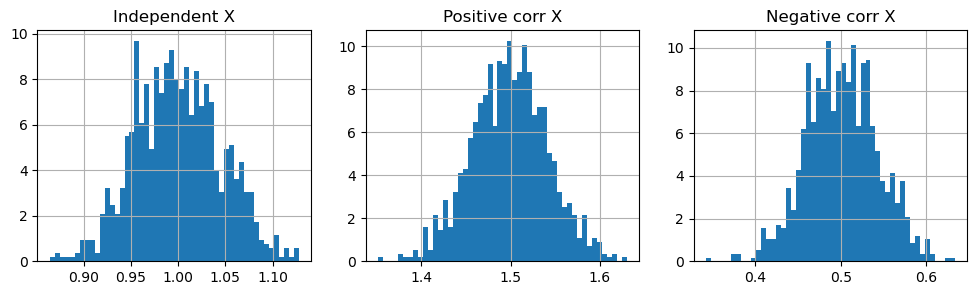

In [29]:
indep_phis = [sim.params[0] for sim in indep_fit]
up_phis = [sim.params[0] for sim in up_fit]
down_phis = [sim.params[0] for sim in down_fit]
plot_data = {"Independent X":indep_phis, "Positive corr X": up_phis, "Negative corr X": down_phis}
plotter_monte_summary(plot_data)

Few observations with respect to partial regressions:
- When both the random variables are independent/uncorrelated, we can see that the OLS estimator converges to form a close distribution around the true parameter($1$). This is consistent with the fact that under independence, we are able to consistently estimate the true value of the parameter without bias
- However, in presence of correlation between the independent variables, we see significant bias in the estimator with it being shifted up when the correlation is positive and shifted down otherwise.
- This exercise shows the significance of dropping variables when performing a regression. If these variables are independent of the other regressors, then OLS would be BLUE, otherwise we end up with a significant amount of bias due to the intercorrelation between the dropped variable and regressors